In [13]:
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
import torch
import torch.utils.data as data 

from cv2 import aruco
from omegaconf import OmegaConf
from torch.nn.parallel import DistributedDataParallel as DDP

# Custom imports
from contrastive_learning.datasets.state_dataset import StateDataset
from contrastive_learning.tests.test_model import load_sbfd, save_all_embeddings, get_closest_embeddings
from contrastive_learning.tests.test_data import plot_state, plot_rvec_tvec
from contrastive_learning.datasets.dataloaders import get_dataloaders

### Model Loading
Load the trans and the position encoder that will be used in testing the positions

In [2]:
# Start the multiprocessing to load the saved models properly
os.environ["MASTER_ADDR"] = "localhost"
os.environ["MASTER_PORT"] = "29504"

torch.distributed.init_process_group(backend='gloo', rank=0, world_size=1)
torch.cuda.set_device(0)

In [3]:
# Set the device and out_dir
device = torch.device('cuda:0')
out_dir = '/home/irmak/Workspace/DAWGE/contrastive_learning/out/2022.07.20/16-23_sbfd_ue_False_lf_mse_bs_64_hd_64_lr_0.001_zd_8'
cfg = OmegaConf.load(os.path.join(out_dir, '.hydra/config.yaml'))
if cfg.agent.use_encoder == False:
    cfg.z_dim = cfg.pos_dim*2
pos_encoder_path = os.path.join(out_dir, 'models/pos_encoder.pt')
trans_path = os.path.join(out_dir, 'models/trans.pt')
fps = 15

# Load the position encoder and forward linear model
pos_encoder, trans = load_sbfd(cfg, device, pos_encoder_path, trans_path)

In [4]:
print('pos_encoder: {}, trans: {}'.format(pos_encoder, trans))

pos_encoder: DistributedDataParallel(
  (module): PosToEmbedding(
    (model): Sequential(
      (0): Linear(in_features=12, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=12, bias=True)
    )
  )
), trans: DistributedDataParallel(
  (module): Transition(
    (model): Sequential(
      (0): Linear(in_features=20, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): ReLU()
      (4): Linear(in_features=64, out_features=128, bias=True)
      (5): ReLU()
      (6): Linear(in_features=128, out_features=256, bias=True)
      (7): ReLU()
      (8): Linear(in_features=256, out_features=128, bias=True)
      (9): ReLU()
      (10): Linear(in_features=128, out_features=64, bias=True)
      (11): ReLU()
      (12): Linear(in_features=64, out_features=12, bias=True)
    )
  )
)


### Dump all the embeddings / positions
Dump or get all the embeddings index by index to the `out_dir`. 
These embeddings will be used to get the closest kth positions

In [5]:
def get_all_pos(cfg, data_loader):
    all_curr_pos = np.zeros((len(data_loader.dataset), cfg.pos_dim*2))
    for i,batch in enumerate(data_loader):
        curr_pos, _, _ = [b for b in batch]
        all_curr_pos[i*cfg.batch_size:(i+1)*cfg.batch_size, :] = curr_pos.detach().numpy()
        
    return all_curr_pos

def get_closest_pos(all_pos, curr_pos, k):
    curr_pos = curr_pos.cpu().detach().numpy()
    dist = np.linalg.norm(all_pos - curr_pos, axis=1)
    closest_pos_idx = np.argsort(dist)[:k]
    
    return closest_pos_idx

In [6]:
# Create a whole dataset and dump all the embeddings to the out_dir
data_dir = '/home/irmak/Workspace/DAWGE/src/dawge_planner/data'
dataset = StateDataset(data_dir)
data_loader = data.DataLoader(dataset, batch_size=cfg.batch_size, shuffle=False, num_workers=4)
if cfg.agent.use_encoder:
    # Use same method that is used on resnet18 cpn testing
    # We are basically doing the same thing - all and all next embeddings in the dataset is saved in out_dir with this
    save_all_embeddings(device, len(dataset), cfg.z_dim, pos_encoder, data_loader, out_dir) 
else:
    all_pos = get_all_pos(cfg, data_loader)

### Predict next embeddings for the test dataset
1. Load the `test_loader` using `get_dataloaders` 
2. Predict the next embeddings using `trans` and `pos_encoder`.
3. Find the closest embeddings to the predicted next embeddings. (And their index).
4. Get the indexed item from the whole dataset.

In [7]:
cfg.batch_size = 16
_, test_loader, _ = get_dataloaders(cfg)

In [8]:
print(len(test_loader.dataset))
batch = next(iter(test_loader))
curr_pos, next_pos, action = [b.to(device) for b in batch]
if cfg.agent.use_encoder:
    z, z_next = pos_encoder(curr_pos), pos_encoder(next_pos)
    z_delta = trans(z, action)
    z_next_predict = z + z_delta
    print('z.shape: {}, z_next.shape: {}, z_next_predict.shape: {}'.format(
        z.shape, z_next.shape, z_next_predict.shape
    ))
else:
    pos_delta = trans(curr_pos, action)
    pos_next_predict = curr_pos + pos_delta

563


In [9]:
print(curr_pos.shape)

torch.Size([16, 12])


In [18]:
CAMERA_INTRINSICS = np.array([[612.82019043,   0.        , 322.14050293],
                              [  0.        , 611.48303223, 247.9083252 ],
                              [  0.        ,   0.        ,   1.        ]])

def plot_rvec_tvec(ax, curr_pos, use_img=False, img=None): # Color scheme is to have an alternative color for polygon colors
    if use_img == False:
        img_shape = (720, 1280, 3)
        blank_image = np.ones(img_shape, np.uint8) * 255
        img = ax.imshow(blank_image.copy())

    for j in range(2):
        curr_rvec_tvec = curr_pos[j*6:(j+1)*6]
        if j == 0:
            frame_axis = aruco.drawAxis(img.get_array().copy(),
                CAMERA_INTRINSICS,
                np.zeros((5)),
                curr_rvec_tvec[:3], curr_rvec_tvec[3:],
                0.01)
        else:
            frame_axis = aruco.drawAxis(frame_axis.copy(),
                CAMERA_INTRINSICS,
                np.zeros((5)),
                curr_rvec_tvec[:3], curr_rvec_tvec[3:],
                0.01)

    img.set_array(frame_axis) # If use_img is true then img will not be none
    ax.plot()

    return img

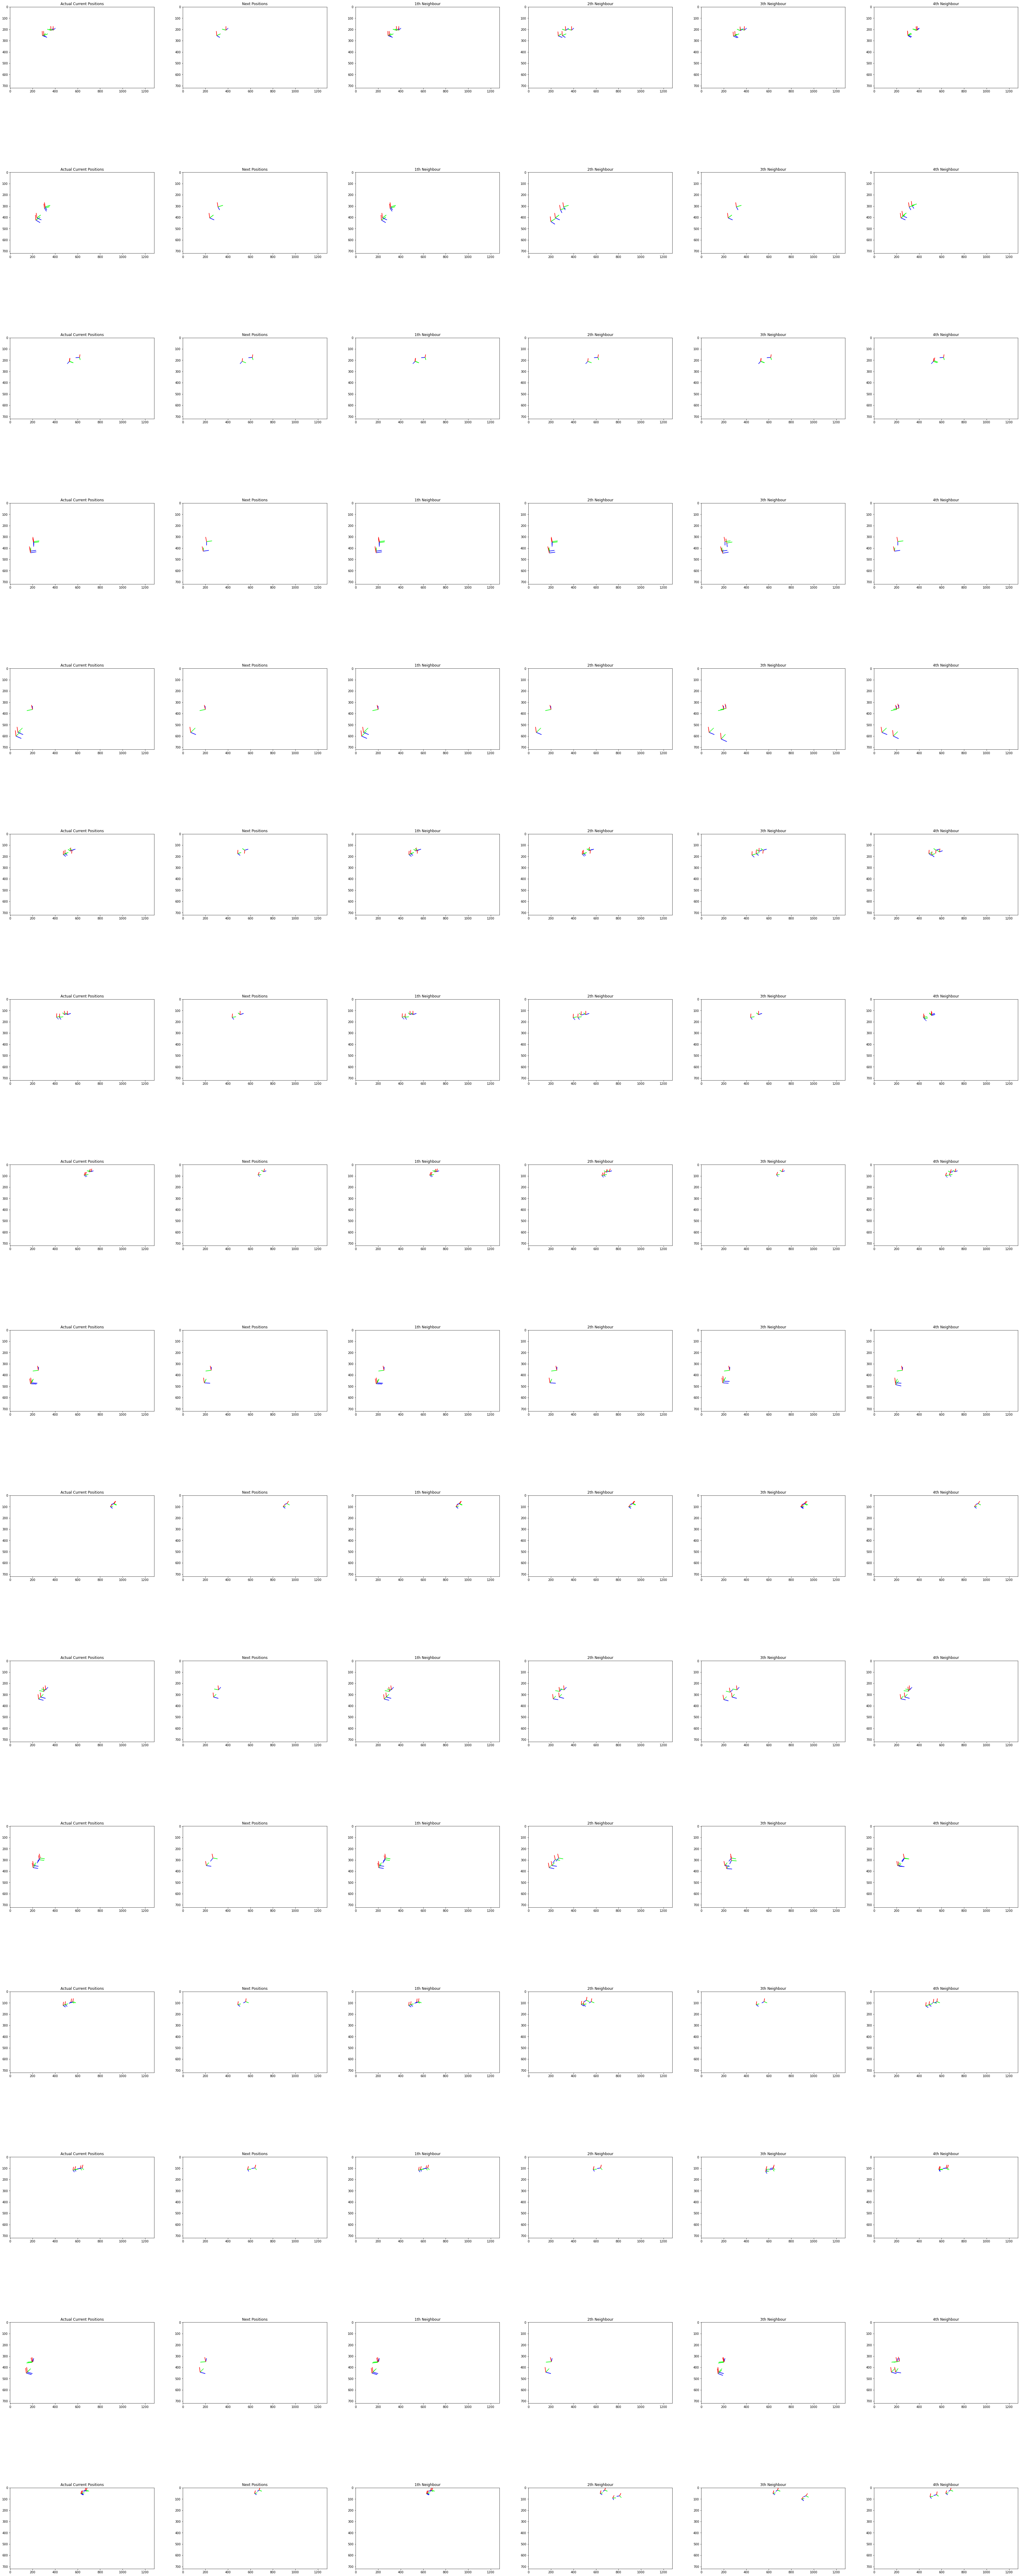

In [19]:
# Plot the current and next positions 
k = 4 # k stands for the kth nearest neighbour
nrows = cfg.batch_size
ncols = k+2 # kth nearest neighbours and current and next position
fig, axs = plt.subplots(figsize=(ncols*10,nrows*10), nrows=nrows, ncols=ncols)
cfg.pos_type = 'rvec_tvec' # or corners

for i in range(cfg.batch_size):
    
    action_np = dataset.denormalize_action(action[i].cpu().detach().numpy())
    if cfg.pos_type == 'corners':
        curr_pos_np = dataset.denormalize_corner(curr_pos[i].cpu().detach().numpy())
        next_pos_np = dataset.denormalize_corner(next_pos[i].cpu().detach().numpy())
    elif cfg.pos_type == 'rvec_tvec':
        curr_pos_np = dataset.denormalize_pos_rvec_tvec(curr_pos[i].cpu().detach().numpy())
        next_pos_np = dataset.denormalize_pos_rvec_tvec(next_pos[i].cpu().detach().numpy())
    
    # Plot the current position
    axs[i,0].set_title("Actual Current Positions")
    if cfg.pos_type == 'corners':
        plot_state(axs[i,0], curr_pos_np, True, action_np, fps, color_scheme=1)
        plot_state(axs[i,0], next_pos_np, plot_action=False, color_scheme=2)
    elif cfg.pos_type == 'rvec_tvec':
        img = plot_rvec_tvec(axs[i,0], curr_pos_np)
        plot_rvec_tvec(axs[i,0], next_pos_np, use_img=True, img=img)
    
    # Plot the next state
    axs[i,1].set_title("Next Positions")
    if cfg.pos_type == 'corners':
        plot_state(axs[i,1], next_pos_np, plot_action=False, color_scheme=1)
    elif cfg.pos_type == 'rvec_tvec':
        plot_rvec_tvec(axs[i,1], next_pos_np)
    
    # TODO: plot the k nearest neighbours - all of them should be plotted on top of the next positions
    curr_obs = curr_pos[i:i+1] if i < cfg.batch_size-1 else curr_pos[i:]
    if cfg.agent.use_encoder:
        closest_idx = get_closest_embeddings(
            out_dir = out_dir, 
            encoder = pos_encoder,
            obs = curr_obs,
            k = k)
    else:
        closest_idx = get_closest_pos(
            all_pos,
            curr_obs,
            k
        )
    for j in range(k):
        kth_pos, _, _ = dataset.getitem(closest_idx[j])
        axs[i,j+2].set_title("{}th Neighbour".format(j+1))
        if cfg.pos_type == 'corners':
            kth_pos_np = dataset.denormalize_corner(kth_pos.cpu().detach().numpy())
            plot_state(axs[i,j+2], next_pos_np, plot_action=False, color_scheme=1)
            plot_state(axs[i,j+2], kth_pos_np, plot_action=False, color_scheme=2)
        elif cfg.pos_type == 'rvec_tvec':
            kth_pos_np = dataset.denormalize_pos_rvec_tvec(kth_pos.cpu().detach().numpy())
            img = plot_rvec_tvec(axs[i,j+2], kth_pos_np)
            plot_rvec_tvec(axs[i,j+2], next_pos_np, use_img=True, img=img)
        
plt.savefig(os.path.join(out_dir, 'sbfd_test.jpg'))